# Simple HRNet
This is a light Google Colab notebook showing how to use the [simple-HRNet](https://github.com/stefanopini/simple-HRNet) repository.

It includes the conversion to TensorRT and a test of the converted model.
Please skip the section "TensorRT" if not interested.

Initial idea of running on Google Colab by @basicvisual, initial implementation by @wuyenlin (see [issue #84](https://github.com/stefanopini/simple-HRNet/issues/84)).

## Pytorch

### Clone the repo and install the dependencies

In [1]:
# clone the repo
!git clone https://github.com/stefanopini/simple-HRNet.git

Cloning into 'simple-HRNet'...
remote: Enumerating objects: 420, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 420 (delta 85), reused 73 (delta 73), pack-reused 319 (from 1)
Receiving objects: 100% (420/420), 78.05 MiB | 22.63 MiB/s, done.
Resolving deltas: 100% (217/217), done.


In [2]:
%cd simple-HRNet
!pwd

/content/simple-HRNet
/content/simple-HRNet


In [3]:
# install requirements
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.0/122.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.1 MB/s eta 0:00:00


In [4]:
# install vlc to get video codecs
!apt install vlc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-freefont-ttf liba52-0.7.4 libaa1 libaribb24-0 libcddb2 libdca0 libdvbpsi10 libdvdnav4
  libdvdread8 libebml5 libevdev2 libfaad2 libgudev-1.0-0 libidn12 libinput-bin libinput10 libixml10
  libjansson4 libkate1 libldb2 liblirc-client0 liblmdb0 liblua5.2-0 liblzo2-2 libmad0 libmatroska7
  libmd4c0 libmpcdec6 libmpeg2-4 libmtdev1 libmtp-common libmtp-runtime libmtp9 libnfs13 libnotify4
  libopenmpt-modplug1 libplacebo192 libprotobuf-lite23 libproxy-tools libproxy1v5 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libqt5x11extras5
  libresid-builder0c2a libsdl-image1.2 libsdl1.2debian libsecret-1-0 libsecret-common libshout3
  libsidplay2 libsmbclient libspatialaudio0 libspeexdsp1 libtag1v5 libtag1v5-vanilla libtalloc2
  libtdb1 libtevent0 libudev1 libupnp13 libva-wayland2 libvlc-bin libvlc5 libvlccore9 l

### Add yolov3
Clone yolov3 for multiprocessing support. This can be skipped for single-person applications or if you plan to use YOLO v5 by Ultralytics.

In [5]:
# download git submodules
!git submodule update --init --recursive

Submodule 'models/detectors/yolo' (https://github.com/eriklindernoren/PyTorch-YOLOv3) registered for path 'models_/detectors/yolo'
Cloning into '/content/simple-HRNet/models_/detectors/yolo'...
Submodule path 'models_/detectors/yolo': checked out '47b7c912877ca69db35b8af3a38d6522681b3bb3'


In [6]:
%cd /content/simple-HRNet/models_/detectors/yolo
!pip install -q -r requirements.txt

%cd /content/simple-HRNet

/content/simple-HRNet/models_/detectors/yolo
/content/simple-HRNet


In [7]:
%cd /content/simple-HRNet/models_/detectors/yolo/weights
!sh download_weights.sh

%cd /content/simple-HRNet

/content/simple-HRNet/models_/detectors/yolo/weights
--2024-12-02 13:30:24--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  19.4MB/s    in 10s     

2024-12-02 13:30:34 (23.1 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2024-12-02 13:30:34--  https://pjreddie.com/media/files/yolov3-tiny.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35434956 (34M) [application/octet-stream]
Saving to: ‘yolov3-tiny.weights’

yolov3-tiny.weights 100%[===================>]  33.79M  7.40MB/s    in 6.2s    

2024-12-02 13:30:41 (5.44 MB/s) - ‘yolo

### Download HRNet pre-trained weights and test video

Download any of the supported official weights listed [here](https://github.com/stefanopini/simple-HRNet/#installation-instructions).

In the following, we download the weights `pose_hrnet_w48_384x288.pth` from the official Drive link.
Download of other weights (e.g. `pose_hrnet_w32_256x192.pth`) as well as weights from private Drives is supported too.

In [8]:
!pip install --upgrade --no-cache-dir gdown

In [9]:
# download weights

# create weights folder
%cd /content/simple-HRNet
!mkdir weights
%cd /content/simple-HRNet/weights

# download weights pose_hrnet_w48_384x288.pth
!gdown 1UoJhTtjHNByZSm96W3yFTfU5upJnsKiS

# download weights pose_hrnet_w32_256x192.pth
!gdown 1zYC7go9EV0XaSlSBjMaiyE_4TcHc_S38

# download weights pose_hrnet_w32_256x256.pth
!gdown 1_wn2ifmoQprBrFvUCDedjPON4Y6jsN-v

# # download weights from your own Google Drive
# from glob import glob
# from google.colab import drive
# drive.mount('/content/drive')
# w_list = glob("/content/drive/<your drive folder>/*.pth")
# if not w_list:
#   raise FileNotFoundError("You haven't downloaded any pre-trained weights!")

%cd /content/simple-HRNet

/content/simple-HRNet
/content/simple-HRNet/weights
Downloading...
From (original): https://drive.google.com/uc?id=1UoJhTtjHNByZSm96W3yFTfU5upJnsKiS
From (redirected): https://drive.google.com/uc?id=1UoJhTtjHNByZSm96W3yFTfU5upJnsKiS&confirm=t&uuid=a82efa15-5cb4-444b-98cc-00b510cf00ab
To: /content/simple-HRNet/weights/pose_hrnet_w48_384x288.pth
100% 255M/255M [00:02<00:00, 118MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1zYC7go9EV0XaSlSBjMaiyE_4TcHc_S38
From (redirected): https://drive.google.com/uc?id=1zYC7go9EV0XaSlSBjMaiyE_4TcHc_S38&confirm=t&uuid=f2d4317c-cefa-4f02-81f1-b1b793d99db2
To: /content/simple-HRNet/weights/pose_hrnet_w32_256x192.pth
100% 115M/115M [00:02<00:00, 52.4MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1_wn2ifmoQprBrFvUCDedjPON4Y6jsN-v
From (redirected): https://drive.google.com/uc?id=1_wn2ifmoQprBrFvUCDedjPON4Y6jsN-v&confirm=t&uuid=1fd97541-dda7-43bf-924c-85d4db299c9e
To: /content/simple-HRNet/weights/pose_hrnet_w32_2

In [10]:
# download a publicly available video (or just get your own)
!wget https://commondatastorage.googleapis.com/gtv-videos-bucket/sample/WeAreGoingOnBullrun.mp4

--2024-12-02 13:31:11--  https://commondatastorage.googleapis.com/gtv-videos-bucket/sample/WeAreGoingOnBullrun.mp4
Resolving commondatastorage.googleapis.com (commondatastorage.googleapis.com)... 142.250.101.207, 142.251.2.207, 74.125.137.207, ...
Connecting to commondatastorage.googleapis.com (commondatastorage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13183260 (13M) [video/mp4]
Saving to: ‘WeAreGoingOnBullrun.mp4’

WeAreGoingOnBullrun 100%[===================>]  12.57M  --.-KB/s    in 0.09s   

2024-12-02 13:31:11 (140 MB/s) - ‘WeAreGoingOnBullrun.mp4’ saved [13183260/13183260]



### Test the API


In [11]:
import cv2
import requests
import matplotlib.pyplot as plt
import torch
from skimage import io
from PIL import Image
from SimpleHRNet import SimpleHRNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # singleperson, COCO weights
# model = SimpleHRNet(48, 17, "./weights/pose_hrnet_w48_384x288.pth", multiperson=False, device=device)

# # multiperson w/ YOLOv3, COCO weights
# model = SimpleHRNet(48, 17, "./weights/pose_hrnet_w48_384x288.pth", device=device)

# # multiperson w/ YOLOv3, COCO weights, small model
# model = SimpleHRNet(32, 17, "./weights/pose_hrnet_w32_256x192.pth", device=device)

# # multiperson w/ YOLOv3, MPII weights
# model = SimpleHRNet(32, 16, "./weights/pose_hrnet_w32_256x256.pth", device=device)

# # multiperson w/ YOLOv5 (medium), COCO weights
# model = SimpleHRNet(48, 17, "./weights/pose_hrnet_w48_384x288.pth", yolo_version='v5', yolo_model_def='yolov5m', device=device)

# multiperson w/ YOLOv5 nano, COCO weights, small model
model = SimpleHRNet(32, 17, "./weights/pose_hrnet_w32_256x192.pth", yolo_version='v5', yolo_model_def='yolov5n', device=device)

url = 'http://images.cocodataset.org/val2017/000000097278.jpg'
im = Image.open(requests.get(url, stream=True).raw)
image = io.imread(url)

joints = model.predict(image)

/content/simple-HRNet/SimpleHRNet.py:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=self.device)


device: 'cuda' - 1 GPU(s) will be used


/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2024-12-2 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

100%|██████████| 3.87M/3.87M [00:00<00:00, 75.9MB/s]

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients, 4.5 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
WARNING ⚠️ NMS time limit 0.550s exceeded


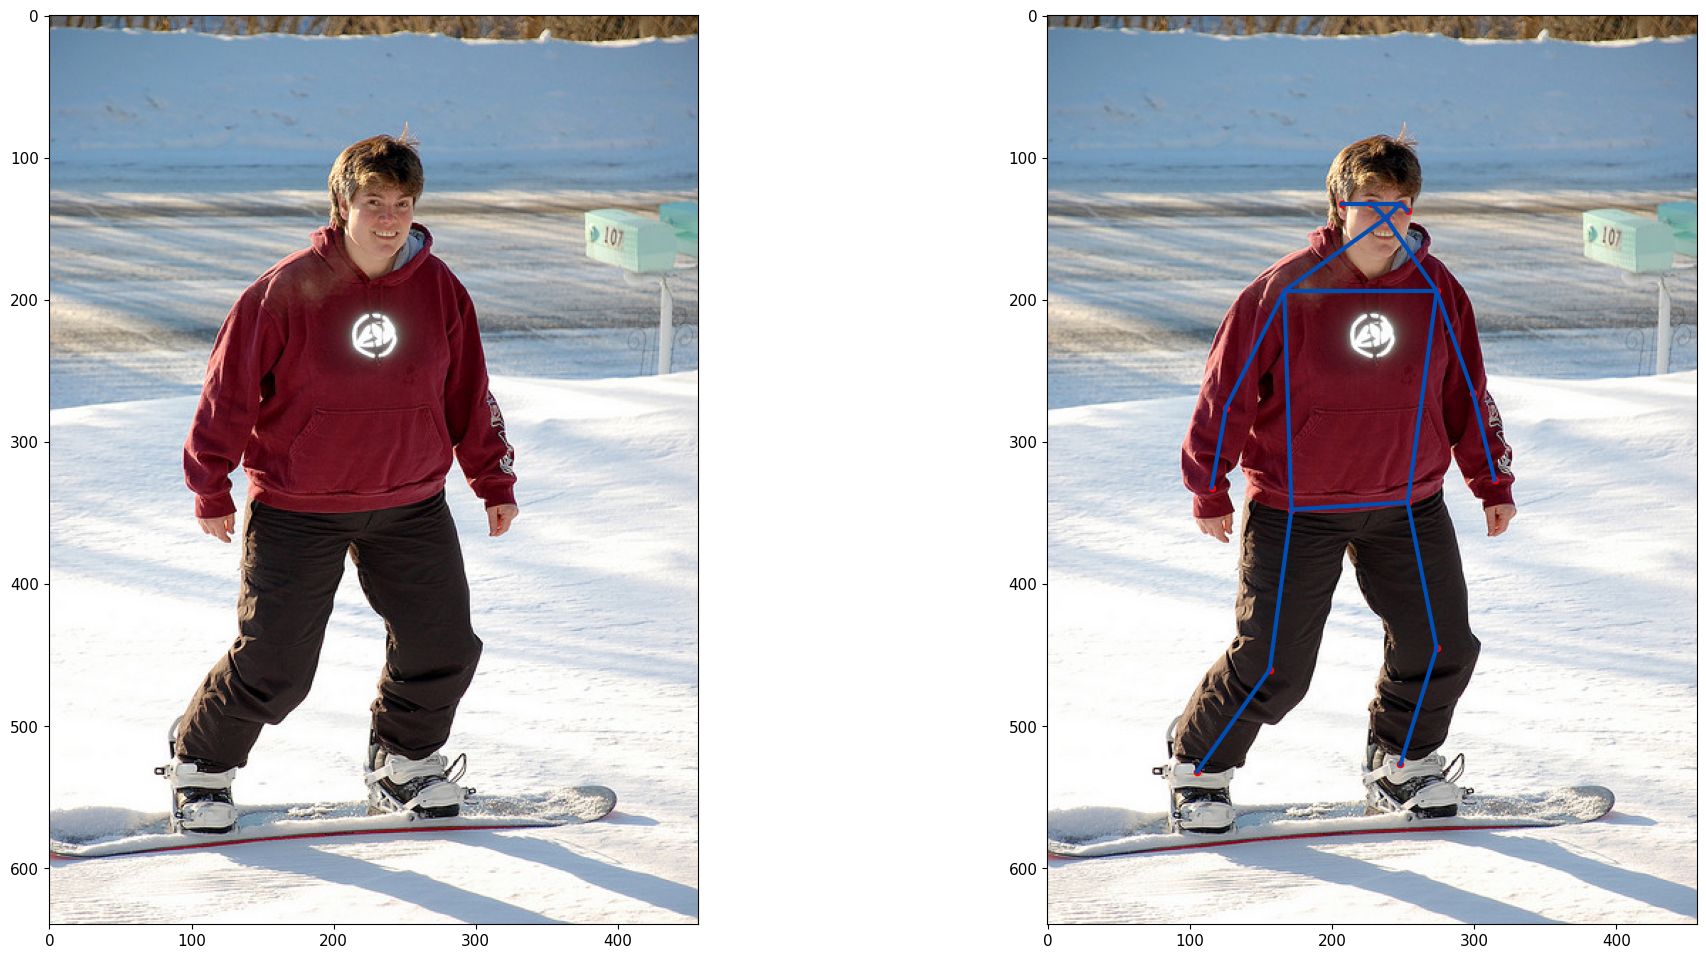

In [12]:
%matplotlib inline
from misc.visualization import joints_dict

def plot_joints(ax, output):
    bones = joints_dict()["coco"]["skeleton"]
    # bones = joints_dict()["mpii"]["skeleton"]

    for bone in bones:
        xS = [output[:,bone[0],1], output[:,bone[1],1]]
        yS = [output[:,bone[0],0], output[:,bone[1],0]]
        ax.plot(xS, yS, linewidth=3, c=(0,0.3,0.7))
    ax.scatter(joints[:,:,1],joints[:,:,0], s=20, c='r')

fig = plt.figure(figsize=(60/2.54, 30/2.54))
ax = fig.add_subplot(121)
ax.imshow(Image.open(requests.get(url, stream=True).raw))
ax = fig.add_subplot(122)
ax.imshow(Image.open(requests.get(url, stream=True).raw))
plot_joints(ax, joints)
plt.show()

### Test the live script
This step can be skipped if interested in the TensorRT conversion.

In [13]:
# # test the live script with default params (multiperson with yolo v3)
# !python ./scripts/live-demo.py --filename WeAreGoingOnBullrun.mp4 --save_video

# # test the live script with tiny yolo (v3)
# !python ./scripts/live-demo.py --filename WeAreGoingOnBullrun.mp4 --save_video --use_tiny_yolo

# # test the live script with yolo v5
# !python ./scripts/live-demo.py --filename WeAreGoingOnBullrun.mp4 --save_video --yolo_version v5

# test the live script with tiny yolo v5 (tensorrt yolo v5)
!python ./scripts/live-demo.py --filename WeAreGoingOnBullrun.mp4 --save_video --yolo_version v5 --use_tiny_yolo

/content/simple-HRNet/SimpleHRNet.py:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=self.device)
device: 'cuda' - 1

Now check out the video output.avi


## TensorRT
This section install TensorRT 8.5, converts the model to TensorRT (.engine) and tests the converted model.

Tested with TensorRT 8.5.1-1+cuda11.8 and python package tensorrt 8.5.1.7 .

### Install TensorRT
A GPU is needed for this step. Please change the runtime type to "GPU".


In [14]:
# check a GPU runtime is selected
!nvidia-smi

Mon Dec  2 13:33:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0              30W /  70W |    445MiB / 15360MiB |     21%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [15]:
%%bash
wget https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb

dpkg -i nvidia-machine-learning-repo-*.deb
apt-get update

sudo apt-get install libnvinfer8 python3-libnvinfer

Selecting previously unselected package nvidia-machine-learning-repo-ubuntu1804.
(Reading database ... 126217 files and directories currently installed.)
Preparing to unpack nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb ...
Unpacking nvidia-machine-learning-repo-ubuntu1804 (1.0.0-1) ...
Setting up nvidia-machine-learning-repo-ubuntu1804 (1.0.0-1) ...

The public CUDA GPG key does not appear to be installed.
To install the key, run this command:
sudo apt-key adv --fetch-keys http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/7fa2af80.pub

Ign:1 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:2 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:3 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]

--2024-12-02 13:33:59--  https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.195.19.142
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2926 (2.9K) [application/x-deb]
Saving to: ‘nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb’

     0K ..                                                    100%  177M=0s

2024-12-02 13:33:59 (177 MB/s) - ‘nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb’ saved [2926/2926]

W: GPG error: http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release: The following signatures couldn't be verified because the public key is not available: NO_PUBKEY F60F4B3D7FA2AF80
E: The repository 'http://developer.download.nvidia.com/co

In [16]:
# check TensorRT version
print("TensorRT version: ")
!dpkg -l | grep nvinfer

TensorRT version: 
ii  libnvinfer-plugin10                     10.6.0.26-1+cuda12.6                    amd64        TensorRT plugin libraries
ii  libnvinfer-vc-plugin10                  10.6.0.26-1+cuda12.6                    amd64        TensorRT vc-plugin library
ii  libnvinfer10                            10.6.0.26-1+cuda12.6                    amd64        TensorRT runtime libraries
ii  libnvinfer8                             8.6.1.6-1+cuda12.0                      amd64        TensorRT runtime libraries
ii  python3-libnvinfer                      10.6.0.26-1+cuda12.6                    amd64        Python 3 bindings for TensorRT standard runtime


In [17]:
# install TensorRT for python
!pip install tensorrt

In [18]:
# clone the converion tool torch2trt
%cd /content
!git clone https://github.com/NVIDIA-AI-IOT/torch2trt

/content
Cloning into 'torch2trt'...
remote: Enumerating objects: 4452, done.
remote: Counting objects: 100% (763/763), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 4452 (delta 647), reused 622 (delta 605), pack-reused 3689 (from 1)
Receiving objects: 100% (4452/4452), 7.77 MiB | 13.25 MiB/s, done.
Resolving deltas: 100% (2583/2583), done.


In [19]:
# install torch2trt
%cd /content/torch2trt
!python setup.py install

/content/torch2trt
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

In [20]:
%cd /content/simple-HRNet

/content/simple-HRNet


### Export the model with tensorrt

In [21]:
# Convert the smaller HRNet model to TensorRT - it may take a while...
!python scripts/export-tensorrt-model.py --half \
     --weights "./weights/pose_hrnet_w32_256x192.pth" --hrnet_c 32 --image_resolution '(256, 192)'

/content/simple-HRNet/scripts/export-tensorrt-model.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pose.load_state_dict(torch.load(args.weights))
Starting conversion t

#### [Optional] Export yolov5 with TensorRT

In [22]:
# Optional - Convert yolov5 (nano) to tensorrt too
!python /root/.cache/torch/hub/ultralytics_yolov5_master/export.py --weights yolov5n.pt --include engine --device 0 --half

export: data=../../root/.cache/torch/hub/ultralytics_yolov5_master/data/coco128.yaml, weights=['yolov5n.pt'], imgsz=[640, 640], batch_size=1, device=0, half=True, inplace=False, keras=False, optimize=False, int8=False, per_tensor=False, dynamic=False, cache=, simplify=False, mlmodel=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['engine']
YOLOv5 🚀 2024-12-2 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients, 4.5 GFLOPs

PyTorch: starting from yolov5n.pt with output shape (1, 25200, 85) (3.9 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 241.6 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 5.0s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for 

### Test the tensorrt model

In [23]:
# Run inference with the converted TensorRT model
!python scripts/live-demo.py --enable_tensorrt --filename=WeAreGoingOnBullrun.mp4 --hrnet_weights='weights/hrnet_trt.engine' \
  --hrnet_c 32 --image_resolution "(256, 192)" --yolo_version v5 --use_tiny_yolo --save_video


/content/simple-HRNet/SimpleHRNet.py:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(checkpoint_path))
Loading custom yolov5 model y

Now check out the video output.avi


#추가

In [57]:
# CrowdPose 데이터 다운로드
!git clone https://github.com/Jeff-sjtu/CrowdPose.git
%cd CrowdPose

# annotations 디렉토리 생성 및 데이터 다운로드
!mkdir -p annotations images
!wget -O annotations/crowdpose_train.json https://datasets.com/crowdpose_train.json
!wget -O annotations/crowdpose_val.json https://datasets.com/crowdpose_val.json
!wget -O annotations/crowdpose_test.json https://datasets.com/crowdpose_test.json

# 이미지 데이터 다운로드 (이미지 데이터 경로는 확인 필요)
!wget -O images/train.zip https://datasets.com/crowdpose_images_train.zip
!wget -O images/val.zip https://datasets.com/crowdpose_images_val.zip
!wget -O images/test.zip https://datasets.com/crowdpose_images_test.zip

# 압축 해제
!unzip images/train.zip -d images/train
!unzip images/val.zip -d images/val
!unzip images/test.zip -d images/test

# 상위 디렉토리로 이동
%cd ..

fatal: destination path 'CrowdPose' already exists and is not an empty directory.
/content/simple-HRNet/CrowdPose
--2024-12-02 15:55:50--  https://datasets.com/crowdpose_train.json
Resolving datasets.com (datasets.com)... 104.21.10.16, 172.67.162.28, 2606:4700:3037::ac43:a21c, ...
Connecting to datasets.com (datasets.com)|104.21.10.16|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.hindawi.com/crowdpose_train.json [following]
--2024-12-02 15:55:50--  https://www.hindawi.com/crowdpose_train.json
Resolving www.hindawi.com (www.hindawi.com)... 162.159.129.87, 162.159.130.87, 2606:4700:7::a29f:8157, ...
Connecting to www.hindawi.com (www.hindawi.com)|162.159.129.87|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2024-12-02 15:55:51 ERROR 403: Forbidden.

--2024-12-02 15:55:51--  https://datasets.com/crowdpose_val.json
Resolving datasets.com (datasets.com)... 104.21.10.16, 172.67.162.28, 2606:4700:3037::ac43:a21

In [33]:
!ls configs

crowdpose.yaml


In [58]:
!touch /content/simple-HRNet/datasets/__init__.py


In [59]:
!python training/Train.py --cfg configs/crowdpose.yaml

Traceback (most recent call last):
  File "/content/simple-HRNet/training/Train.py", line 11, in <module>
    from datasets.HumanPoseEstimation import HumanPoseEstimationDataset
ModuleNotFoundError: No module named 'datasets'


In [46]:
!python scripts/export-tensorrt-model.py \
  --weights "./weights/pose_hrnet_w32_256x192.pth" \
  --hrnet_c 32 \
  --hrnet_j 17 \
  --image_resolution "(256,192)" \
  --batch_size 1 \
  --output_path outputs/model_trt.plan

/content/simple-HRNet/scripts/export-tensorrt-model.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pose.load_state_dict(torch.load(args.weights))
Starting conversion t

In [62]:
!python Train.py --cfg configs/crowdpose.yaml

In [63]:
!python Test.py --cfg configs/crowdpose.yaml --weights outputs/model_trt.plan

In [64]:
from utils.visualization import visualize_predictions

# 모델이 출력한 JSON 결과 파일 경로
results_file = "outputs/crowdpose/test_results.json"

# 시각화 수행
visualize_predictions(results_file, "CrowdPose/images/test")

ModuleNotFoundError: No module named 'utils.visualization'